# RAVDESS Metadata Extraction and Visualization

This notebook is dedicated to extracting and visualizing metadata for the RAVDESS dataset. We will:
1. Load the dataset metadata.
2. Extract technical details from the audio files.
3. Save the updated metadata.
4. Visualize various aspects of the dataset.


## 1. Loading and Preparing Metadata

In [4]:
import os
import pandas as pd
import numpy as np
import librosa

In [5]:
# Define mappings for the filename components
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

intensity_map = {
    '01': 'normal', '02': 'strong'
}

statement_map = {
    '01': 'Kids are talking by the door', '02': 'Dogs are sitting by the door'
}

In [6]:
def parse_filename(path):
    filename = path.split("/")[-1]
    parts = filename.split('.')[0].split('-')
    modality = int(parts[0])
    vocal_channel = int(parts[1])
    emotion = emotion_map[parts[2]]
    intensity = intensity_map.get(parts[3], 'N/A')
    statement = statement_map[parts[4]]
    repetition = int(parts[5])
    actor = int(parts[6])
    gender = 'male' if actor % 2 != 0 else 'female'
    
    return {
        'path': path,
        'modality': modality,
        'vocal_channel': vocal_channel,
        'emotion': emotion,
        'intensity': intensity,
        'statement': statement,
        'repetition': repetition,
        'actor': actor,
        'gender': gender
    }

In [7]:
audio_folder = '/kaggle/input/ravdess-emotional-speech-audio'

# Get list of all .wav files in the folder
audio_files = [os.path.join(dirname, filename) 
               for dirname, _, filenames in os.walk('/kaggle/input') 
               for filename in filenames if filename.endswith('.wav')]

# Extract metadata from filenames
metadata = [parse_filename(f) for f in audio_files]

# Convert to DataFrame
df = pd.DataFrame(metadata)

## 2. Extracting Technical Metadata


In [8]:
def extract_audio_metadata(row):
    filename = os.path.join(row['path'])
    if os.path.exists(filename):
        y, sr = librosa.load(filename, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        return pd.Series([sr, duration])
    else:
        return pd.Series([None, None])

# Apply the function to the dataset
df[['sampling_rate', 'duration']] = df.apply(extract_audio_metadata, axis=1)

In [10]:
df.to_csv('RAVDESS_metadata.csv', index=False)

## 3. Visualization

In [11]:
df = pd.read_csv('/kaggle/working/RAVDESS_metadata.csv')

In [12]:
# Visualization functions

import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display


# Funtion to plot gender distribution
def plot_gender_distribution(dataset):
    plt.figure(figsize=(10, 6))
    
    # Plotting gender distribution
    ax = sns.countplot(x='gender', data=dataset)
    
    plt.title('Gender Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Adding exact count on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), 
                    textcoords='offset points')
    
    plt.show()

# Function to plot emotion distribution
def plot_emotion_distribution(dataset):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='emotion', data=dataset)
    plt.title('Emotion Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), 
                    textcoords='offset points')
    plt.show()

def plot_emotion_distribution_pie(dataset):
    plt.figure(figsize=(8, 8))
    
    # Calculate emotion counts
    emotion_counts = dataset['emotion'].value_counts()
    
    # Plotting pie chart
    plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140)
    
    plt.title('Emotion Distribution')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.show()

# Function to plot duration distribution
def plot_duration_distribution(dataset):
    durations = dataset['duration']
    plt.figure(figsize=(10, 6))
    sns.histplot(durations, bins=30, kde=True)
    plt.title('Duration Distribution')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    plt.show()

# Function to plot a sample spectrogram
def plot_spectrogram(audio_file):
    y, sr = librosa.load(audio_file, sr=None)
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

# Function to plot a sample waveform
def plot_waveform(audio_file):
    y, sr = librosa.load(audio_file, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.show()

# Function to plot MFCCs
def plot_mfccs(audio_file):
    y, sr = librosa.load(audio_file, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCCs')
    plt.show()

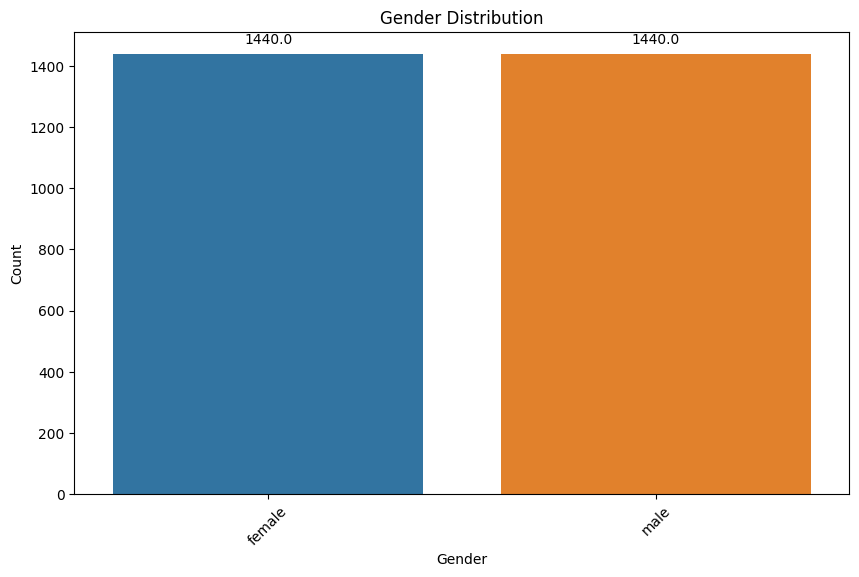

In [14]:
plot_gender_distribution(df)

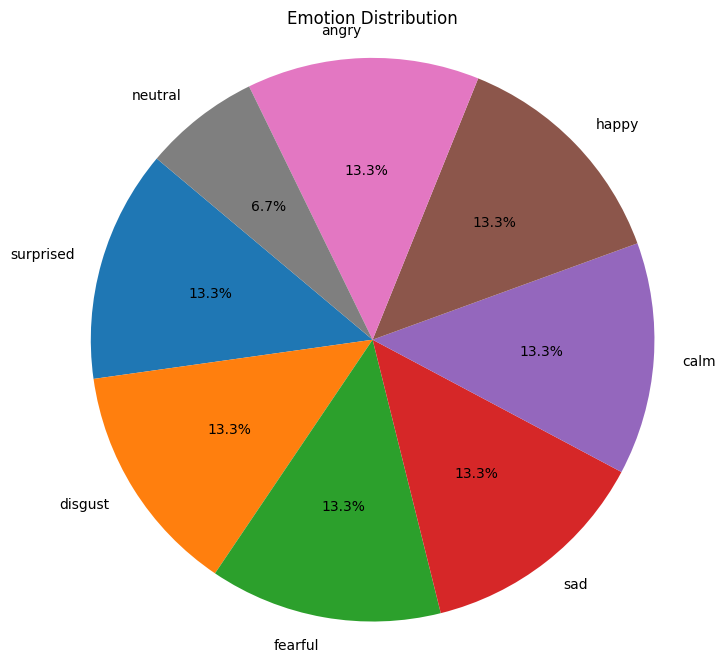

In [15]:
plot_emotion_distribution_pie(df)

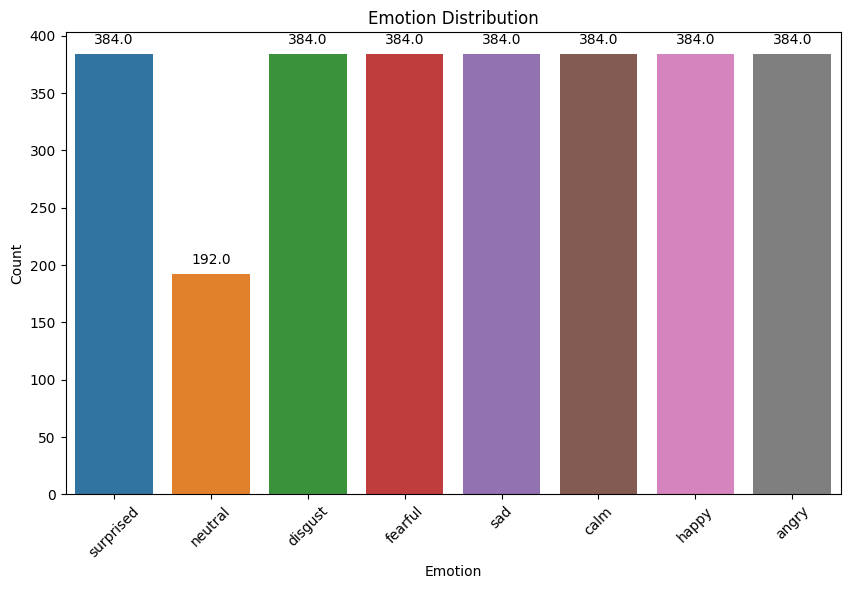

In [16]:
plot_emotion_distribution(df)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


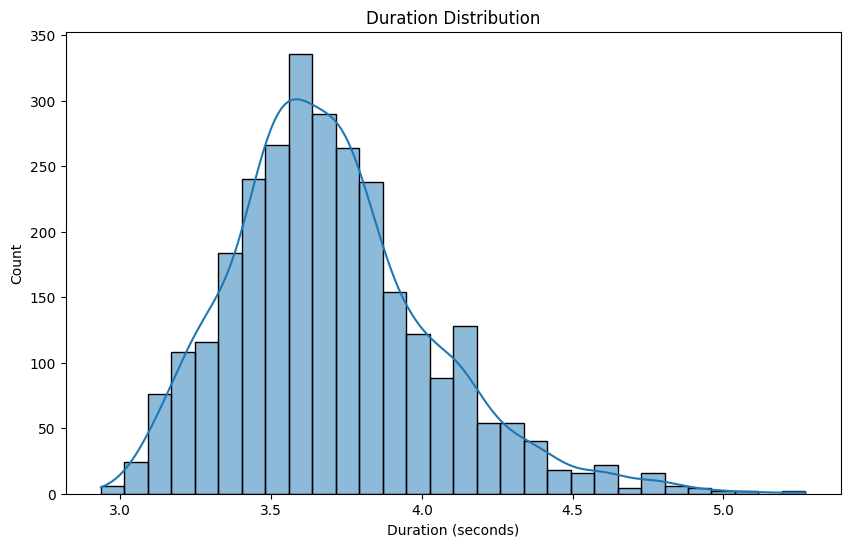

In [17]:
plot_duration_distribution(df)

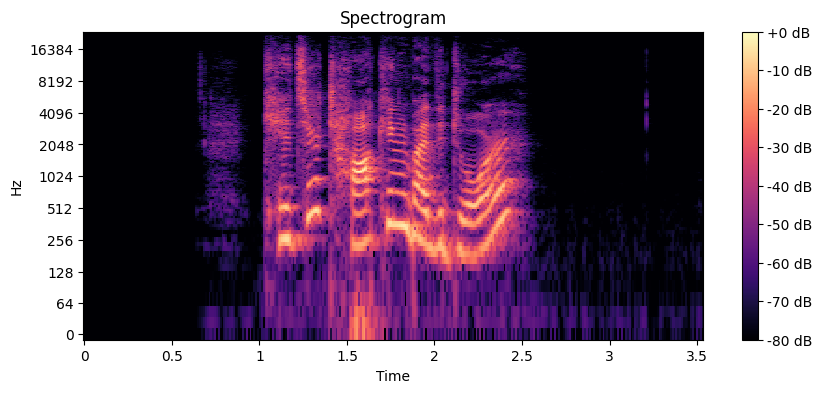

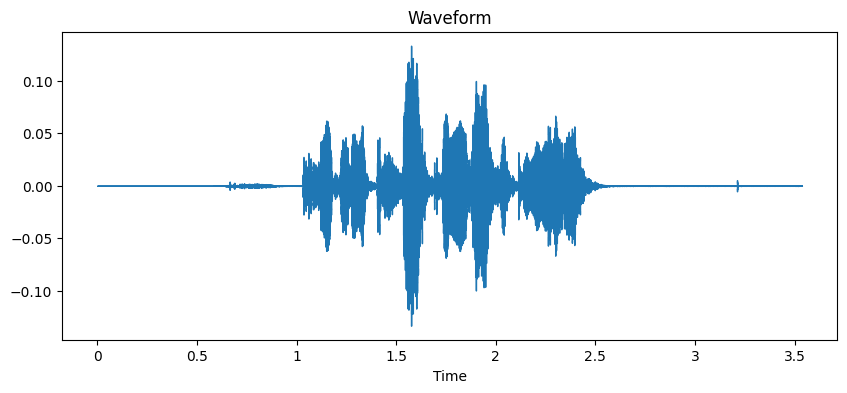

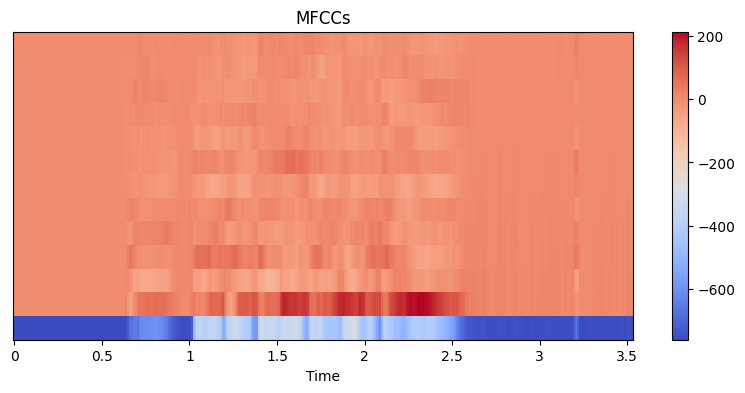

In [18]:
# Sample output
audio_file_path = audio_files[0]
plot_spectrogram(audio_file_path)
plot_waveform(audio_file_path)
plot_mfccs(audio_file_path)

## 4. Conclusion

In this notebook, we successfully:
1. Loaded and prepared metadata for the RAVDESS dataset.
2. Extracted technical details from the audio files.
3. Saved the updated metadata.
4. Visualized various aspects of the dataset.